<a href="https://colab.research.google.com/github/lahmuddin/Machine-Learning-after-Middle-Test/blob/main/Week9/Chapter4/Model%20Selection%2C%20Underfitting%2C%20and%20Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lahmuddin_1103184028_TK-42-G6**

In [1]:
pip install torch torchvision

In [2]:
pip install -U d2l

# **Model Selection, Underfitting, and Overfitting**
http://www.d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html

**Polynomial Regression**

In [3]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [4]:
#Generating the Dataset
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [5]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.6417],
         [ 0.7552]]),
 tensor([[ 1.0000e+00, -1.6417e+00,  1.3476e+00, -7.3745e-01,  3.0267e-01,
          -9.9379e-02,  2.7192e-02, -6.3773e-03,  1.3087e-03, -2.3872e-04,
           3.9191e-05, -5.8491e-06,  8.0021e-07, -1.0105e-07,  1.1850e-08,
          -1.2970e-09,  1.3308e-10, -1.2851e-11,  1.1721e-12, -1.0128e-13],
         [ 1.0000e+00,  7.5521e-01,  2.8517e-01,  7.1788e-02,  1.3554e-02,
           2.0472e-03,  2.5768e-04,  2.7800e-05,  2.6244e-06,  2.2022e-07,
           1.6631e-08,  1.1418e-09,  7.1859e-11,  4.1745e-12,  2.2519e-13,
           1.1338e-14,  5.3514e-16,  2.3773e-17,  9.9744e-19,  3.9646e-20]]),
 tensor([-5.7329,  5.4751]))

In [6]:
#Training and Testing the Model
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [7]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0026073  1.1870314 -3.4011078  5.587975 ]]


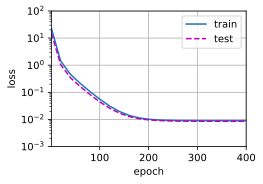

In [8]:
#Third-Order Polynomial Function Fitting (Normal)
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.9868653 4.0974264]]


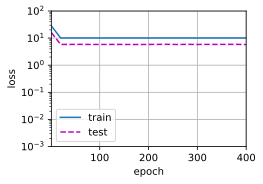

In [9]:
#Linear Function Fitting (Underfitting)
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.999275    1.2728016  -3.3816023   5.1672173  -0.06900414  1.193643
   0.09251606  0.29396352 -0.15008944 -0.10165093 -0.22063209  0.18807742
   0.01144237  0.0436774  -0.0469344   0.01049267 -0.18953696 -0.15800007
  -0.04507504  0.06497151]]


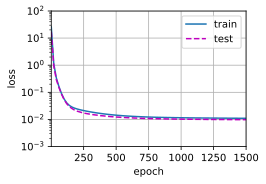

In [10]:
#Higher-Order Polynomial Function Fitting (Overfitting)
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)